Aim: initial size = 10, find setting AL is superior than IID, use default lr
<br> 
Try: (1) n = 1, mini-batches

In [ ]:
import numpy as np
import torch
from torch import nn, distributions
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision import datasets
from dataclasses import dataclass

In [ ]:
mnist_train = datasets.MNIST("../data", train=True, download=True, transform=ToTensor())
mnist_test  = datasets.MNIST("../data", train=False,download=True, transform=ToTensor())
traindataloader = DataLoader(mnist_train, shuffle=True, batch_size=60000)
testdataloader  = DataLoader(mnist_test , shuffle=True, batch_size=10000)
X_train, y_train = next(iter(traindataloader))
X_test , y_test  = next(iter(testdataloader))

X_train = X_train.reshape(60000, -1)
X_test = X_test.reshape(10000, -1)

device = "cuda" if torch.cuda.is_available() else "cpu"


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw




Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
# sepeate train data into (1) initial, (2) pool
initial_idx = np.array([],dtype=int)
for i in range(10):
    idx = np.random.choice(np.where(y_train==i)[0], size=2, replace=False)
    initial_idx = np.concatenate((initial_idx, idx))

X_initial = X_train[initial_idx]
y_initial = y_train[initial_idx]

X_pool = np.delete(X_train, initial_idx, axis=0)
y_pool = np.delete(y_train, initial_idx, axis=0)

In [ ]:
X_pool.shape

torch.Size([59990, 784])

In [ ]:
# BALD Acquisition function (incomplete sampling in paper)
def bald(model_A, model_S1, model_S2, X, n_instances, T = 100):
  
    random_subset = np.random.choice(range(len(X)), size=len(X), replace=False)
    with torch.no_grad():
        x = X[random_subset].to(device)
        outputs = np.stack([torch.exp(model_A(x)).detach().cpu().numpy() for t in range(T)])

    pc = outputs.mean(axis=0)
    H   = (-pc*np.log(pc + 1e-10)).sum(axis=-1)
    E_H = - np.mean(np.sum(outputs * np.log(outputs + 1e-10), axis=-1), axis=0) 
    acquisition = H - E_H
    idx = (-acquisition).argsort()[:n_instances]
    query_idx = random_subset[idx]

    score_A = acquisition[query_idx]
    
    #---------------- score for successors:
    with torch.no_grad():
        output_S1 = np.stack([torch.exp(model_S1(X[query_idx].to(device))).detach().cpu().numpy() for t in range(T)])
        output_S2 = np.stack([torch.exp(model_S2(X[query_idx].to(device))).detach().cpu().numpy() for t in range(T)])

    pc = output_S1.mean(axis=0)
    H   = (-pc*np.log(pc + 1e-10)).sum(axis=-1)
    E_H = - np.mean(np.sum(output_S1 * np.log(output_S1 + 1e-10), axis=-1), axis=0) 
    score_S1 = H - E_H

    pc = output_S2.mean(axis=0)
    H   = (-pc*np.log(pc + 1e-10)).sum(axis=-1)
    E_H = - np.mean(np.sum(output_S2 * np.log(output_S2 + 1e-10), axis=-1), axis=0) 
    score_S2 = H - E_H

    return (query_idx, score_A, score_S1, score_S2) 

In [ ]:
# BALD Acquisition function (in use)
def bald(model_A, model_S1, model_S2, X, n_instances, T = 100):
  
    with torch.no_grad():
        x = X.to(device)
        outputs = np.stack([torch.exp(model_A(x)).detach().cpu().numpy() for t in range(T)])

    pc = outputs.mean(axis=0)
    H   = (-pc*np.log(pc + 1e-10)).sum(axis=-1)
    E_H = - np.mean(np.sum(outputs * np.log(outputs + 1e-10), axis=-1), axis=0) 
    acquisition = H - E_H
    query_idx = (-acquisition).argsort()[:n_instances]

    score_A = acquisition[query_idx]
    
    #---------------- score for successors:
    with torch.no_grad():
        output_S1 = np.stack([torch.exp(model_S1(X[query_idx].to(device))).detach().cpu().numpy() for t in range(T)])
        output_S2 = np.stack([torch.exp(model_S2(X[query_idx].to(device))).detach().cpu().numpy() for t in range(T)])

    pc = output_S1.mean(axis=0)
    H   = (-pc*np.log(pc + 1e-10)).sum(axis=-1)
    E_H = - np.mean(np.sum(output_S1 * np.log(output_S1 + 1e-10), axis=-1), axis=0) 
    score_S1 = H - E_H

    pc = output_S2.mean(axis=0)
    H   = (-pc*np.log(pc + 1e-10)).sum(axis=-1)
    E_H = - np.mean(np.sum(output_S2 * np.log(output_S2 + 1e-10), axis=-1), axis=0) 
    score_S2 = H - E_H

    return (query_idx, score_A, score_S1, score_S2) 

In [ ]:
# IID acquistion:
def iid_acq(model_A, model_S1, model_S2, X, n_instances, T = 100):
    
    query_idx = np.random.choice(range(len(X)), size=n_instances, replace=False)
    with torch.no_grad():
        x = X[query_idx].to(device)
        outputs = np.stack([torch.exp(model_A(x)).detach().cpu().numpy() for t in range(T)])
        output_S1 = np.stack([torch.exp(model_S1(x)).detach().cpu().numpy() for t in range(T)])
        output_S2 = np.stack([torch.exp(model_S2(x)).detach().cpu().numpy() for t in range(T)])

    pc = outputs.mean(axis=0)
    H   = (-pc*np.log(pc + 1e-10)).sum(axis=-1)
    E_H = - np.mean(np.sum(outputs * np.log(outputs + 1e-10), axis=-1), axis=0) 
    score_A = H - E_H
    
    #---------------- score for the other 2 models:
    pc = output_S1.mean(axis=0)
    H   = (-pc*np.log(pc + 1e-10)).sum(axis=-1)
    E_H = - np.mean(np.sum(output_S1 * np.log(output_S1 + 1e-10), axis=-1), axis=0) 
    score_S1 = H - E_H

    pc = output_S2.mean(axis=0)
    H   = (-pc*np.log(pc + 1e-10)).sum(axis=-1)
    E_H = - np.mean(np.sum(output_S2 * np.log(output_S2 + 1e-10), axis=-1), axis=0) 
    score_S2 = H - E_H

    return (query_idx, score_A, score_S1, score_S2) 

In [ ]:
def active_learning_procedure(X_test,
                              y_test,
                              X_pool,
                              y_pool,
                              X_initial,
                              y_initial,
                              n_queries=100, 
                              n_instances=1,
                              sample_strategy = 'bald',
                              Model_A = 1,
                              Model_S1 = 2,
                              Model_S2 = 3):

    pool_idx = list()
    x_train_sample = X_initial
    y_train_sample = y_initial

    valid_idx = np.random.randint(0, len(y_pool), 1000)
    x_valid = X_pool[valid_idx]
    y_valid = y_pool[valid_idx]

    #----- Model A --------------------------
    if (Model_A==1):
        A = Model1(784, 10, data_num = len(x_train_sample)).to(device)
    elif (Model_A ==2 ):
        A = Model2(784, 392, 10, data_num = len(x_train_sample)).to(device)
    elif (Model_A == 3):
        A = Model3(784, [392, 196], 10, data_num = len(x_train_sample)).to(device)
    else:
        print('Invalid option for Model_A')
        return
    optim0 = torch.optim.Adam(A.parameters(), lr=0.001)
    _, _ = train(A, optim0, 1000, x_train_sample, y_train_sample,
                 x_valid, y_valid, verbose = False)
    acquisition_hist  = [eval_acc(A, X_test, y_test)]


    #----- Model S --------------------------
    if (Model_S1 == 1):
        S1 = Model1(784, 10, data_num = len(x_train_sample)).to(device)
    elif (Model_S1 ==2):
        S1 = Model2(784, 392, 10, data_num = len(x_train_sample)).to(device)
    else:
        print('Invalid option for Model_S1')
        return
    optim1 = torch.optim.Adam(S1.parameters(), lr=0.001)
    _, _ = train(S1, optim1, 1000, x_train_sample, y_train_sample,
                 x_valid, y_valid, verbose = False)
    successor1_hist = [eval_acc(S1, X_test, y_test)]

    if (Model_S2 == 1):
        S2 = Model1(784, 10, data_num = len(x_train_sample)).to(device)
    elif (Model_S2 ==3):
        S2 = Model3(784, [392, 196], 10, data_num = len(x_train_sample)).to(device)
    else:
        print('Invalid option for Model_A')
        return   
    optim2 = torch.optim.Adam(S2.parameters(), lr=0.001)
    _, _ = train(S2, optim2, 1000, x_train_sample, y_train_sample,
                 x_valid, y_valid, verbose = False)
    successor2_hist = [eval_acc(S2, X_test, y_test)]

    scores = list()

    for index in range(n_queries):
        # for incomplete sampling (paper):
        #query_idx = np.concatenate([bald(A, X_pool) for n in range(n_instances)])

        # for complete set sampling:
        if (sample_strategy  == 'bald'):
            query_idx, score_A, score_S1, score_S2 = bald(A, S1, S2, X_pool, n_instances)
        elif (sample_strategy == 'iid'):
            query_idx, score_A, score_S1, score_S2 = iid_acq(A, S1, S2, X_pool, n_instances)
        else:
            print('Unexpected sampling strategy')
            return
        
        # record scores:
        scores.append(np.vstack((score_A, score_S1, score_S2)))

        x_train_sample = torch.vstack((x_train_sample, X_pool[query_idx]))
        y_train_sample = torch.cat((y_train_sample,y_pool[query_idx]))

        valid_idx = np.random.randint(0, len(y_pool), 1000)
        x_valid = X_pool[valid_idx]
        y_valid = y_pool[valid_idx]

        # model A:
        if (Model_A==1):
            A = Model1(784, 10, data_num = len(x_train_sample)).to(device)
        elif (Model_A ==2 ):
            A = Model2(784, 392, 10, data_num = len(x_train_sample)).to(device)
        elif (Model_A == 3):
            A = Model3(784, [392, 196], 10, data_num = len(x_train_sample)).to(device)
        else:
            print('Invalid option for Model_A')
            return
        optim0 = torch.optim.Adam(A.parameters(), lr=0.001)
        _, _ = train(A, optim0, 1000, x_train_sample, y_train_sample,
                     x_valid, y_valid, verbose = False)
        acquisition_hist.append(eval_acc(A, X_test, y_test))

        # model S:
        if (Model_S1 == 1):
            S1 = Model1(784, 10, data_num = len(x_train_sample)).to(device)
        elif (Model_S1 ==2):
            S1 = Model2(784, 392, 10, data_num = len(x_train_sample)).to(device)
        else:
            print('Invalid option for Model_S1')
            return   
        optim1 = torch.optim.Adam(S1.parameters(), lr=0.001)
        _, _ = train(S1, optim1, 1000, x_train_sample, y_train_sample,
                    x_valid, y_valid, verbose = False)
        successor1_hist.append(eval_acc(S1, X_test, y_test))

        if (Model_S2 == 1):
            S2 = Model1(784, 10, data_num = len(x_train_sample)).to(device)
        elif (Model_S2 ==3):
            S2 = Model3(784, [392, 196], 10, data_num = len(x_train_sample)).to(device)
        else:
            print('Invalid option for Model_S2')
            return 
        optim2 = torch.optim.Adam(S2.parameters(), lr=0.001)
        _, _ = train(S2, optim2, 1000, x_train_sample, y_train_sample,
                    x_valid, y_valid, verbose = False)
        successor2_hist.append(eval_acc(S2, X_test, y_test))

        
        # delete queried data from pool:
        X_pool = np.delete(X_pool, query_idx, axis=0)
        y_pool = np.delete(y_pool, query_idx, axis=0)

        print('Query {n}: {acc:0.4f}(Model A)    |     {acc_s1:0.4f}(Model S1) - {acc_s2:0.4f}(Model S2) '.format(n=index + 1, 
                                                                                                                  acc=acquisition_hist[-1], 
                                                                                                                  acc_s1 = successor1_hist[-1], 
                                                                                                                  acc_s2 = successor2_hist[-1]))     
        pool_idx.append(query_idx)
    return(acquisition_hist, successor1_hist, successor2_hist, scores, pool_idx)

In [ ]:
class LinearVariational(nn.Module):
    def __init__(self, in_features, out_features, loss_accumulator, data_num, bias=True):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.include_bias = bias        
        self.loss_accumulator = loss_accumulator
        self.data_num = data_num
        
        if getattr(loss_accumulator, 'accumulated_kl_div', None) is None:
            loss_accumulator.accumulated_kl_div = 0

        self.w_mu = nn.Parameter(
            torch.FloatTensor(in_features, out_features).normal_(mean=0, std=0.001)
        )
        # proxy for variance
        # log(1 + exp(ρ))◦ eps
        self.w_p = nn.Parameter(
            torch.FloatTensor(in_features, out_features).normal_(mean=-2.5, std=0.001)
        )
        if self.include_bias:
            self.b_mu = nn.Parameter(
                torch.zeros(out_features)
            )
            self.b_p = nn.Parameter(
                torch.zeros(out_features)
            )
        
    def reparameterize(self, mu, p):
        sigma = torch.log(1 + torch.exp(p)) 
        eps = torch.randn_like(sigma)
        return mu + (eps * sigma)
    
    def kl_divergence(self, z, mu_theta, p_theta, batch_size, prior_sd=1):
        log_prior = distributions.Normal(0, prior_sd).log_prob(z) 
        log_p_q = distributions.Normal(mu_theta, torch.log(1 + torch.exp(p_theta))).log_prob(z) 
        return (log_p_q - log_prior).mean() * ( batch_size/self.data_num)

    def forward(self, x):
        w = self.reparameterize(self.w_mu, self.w_p)
        
        if self.include_bias:
            b = self.reparameterize(self.b_mu, self.b_p)
        else:
            b = 0
            
        z = x @ w + b
        
        self.loss_accumulator.accumulated_kl_div += self.kl_divergence(w, 
                                                             self.w_mu,
                                                             self.w_p,
                                                             len(x)
                                                             )
        if self.include_bias:
            self.loss_accumulator.accumulated_kl_div += self.kl_divergence(b, 
                                                                 self.b_mu, 
                                                                 self.b_p,
                                                                 len(x)
                                                                 )
        return z


@dataclass
class KL:
    accumulated_kl_div = 0

def det_loss(y, y_pred, model):
    reconstruction_error = F.nll_loss(y_pred, y,reduction="mean")
    kl = model.accumulated_kl_div
    model.reset_kl_div()
    return reconstruction_error + kl



In [ ]:
class Model1(nn.Module):
    def __init__(self, in_size, out_size, data_num):
        super().__init__()
        self.kl_loss = KL
        
        self.layers = nn.Sequential(
            LinearVariational(in_size, out_size, self.kl_loss, data_num),
            nn.LogSoftmax(dim = 1)
        )
    
    @property
    def accumulated_kl_div(self):
        return self.kl_loss.accumulated_kl_div
    
    def reset_kl_div(self):
        self.kl_loss.accumulated_kl_div = 0
            
    def forward(self, x):
       # x = x.view(-1, 784)
        return self.layers(x)

class Model2(nn.Module):
    def __init__(self, in_size, hidden_size, out_size, data_num):
        super().__init__()
        self.kl_loss = KL
        
        self.layers = nn.Sequential(
            LinearVariational(in_size, hidden_size, self.kl_loss, data_num),
            nn.ReLU(),
            LinearVariational(hidden_size, out_size, self.kl_loss, data_num),
            nn.LogSoftmax(dim = 1)
        )
    
    @property
    def accumulated_kl_div(self):
        return self.kl_loss.accumulated_kl_div
    
    def reset_kl_div(self):
        self.kl_loss.accumulated_kl_div = 0
            
    def forward(self, x):
       # x = x.view(-1, 784)
        return self.layers(x)

class Model3(nn.Module):
    def __init__(self, in_size, hidden_size, out_size, data_num):
        super().__init__()
        self.kl_loss = KL
        
        self.layers = nn.Sequential(
            LinearVariational(in_size, hidden_size[0], self.kl_loss, data_num),
            nn.ReLU(),
            LinearVariational(hidden_size[0], hidden_size[1], self.kl_loss, data_num),
            nn.ReLU(),
            LinearVariational(hidden_size[1], out_size, self.kl_loss, data_num),
            nn.LogSoftmax(dim = 1)
        )
    
    @property
    def accumulated_kl_div(self):
        return self.kl_loss.accumulated_kl_div
    
    def reset_kl_div(self):
        self.kl_loss.accumulated_kl_div = 0
            
    def forward(self, x):
       # x = x.view(-1, 784)
        return self.layers(x)

In [ ]:
# Train
def train(model, optimizer, num_epoch, X_initial, y_initial, 
                                                 X_valid, y_valid, verbose = False):
    train_ls = list()
    valid_ls = list()
    train_kl = list()
    valid_kl = list()
    
    valid_loader = DataLoader(list(zip(X_valid,  y_valid)), 
                      shuffle=True, batch_size = len(X_valid))
    train_loader = DataLoader(list(zip(X_initial,  y_initial)), 
                      shuffle=True, batch_size = 10)

    for epoch in range(num_epoch):
        ls = 0
        acc_kl = 0
        num_correct = 0
        data_num = 0

        model.train()
        for bs_num, (x, y) in enumerate(train_loader):

            x = x.to(device)
            y = y.to(device)

            # forward:
            y_pred = model(x)
            loss = det_loss(y, y_pred, model)
            ls += loss.item()
            print(model.accumulated_kl_div)
            acc_kl += model.accumulated_kl_div
            model.reset_kl_div()


            # backward:
            optimizer.zero_grad() # remove grad from forward prop
            loss.backward()

            # update gradient:
            optimizer.step()

            # accuracy:
            #_, pred = torch.max(y_pred,1)
            #num_correct += (pred == y).sum().item()

            data_num += len(y)

        train_kl.append(acc_kl)

        ls = ls/data_num
        val_ls = eval_ls(model, valid_loader)
        if verbose:
            print(epoch+1)
            print(f'\tLoss: {ls:.4f}(train)\t|\tLoss: {val_ls:.4f}(valid)')
        train_ls.append(ls)
        valid_ls.append(val_ls)

        # access early stopping:
        trigger = (np.array(train_ls[epoch-50:]) < np.array(valid_ls[epoch-50:])).sum()/50
        if (trigger > 0.5):
            if verbose:
                print('Epoch {} : Early Stopping - past 50 epochs half val_ls > train_ls'.format(epoch))
            break
        

    return(train_ls, valid_ls)


def eval_ls(model, loader):
    ls = 0
    data_num = 0

    model.eval()
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)
            loss = det_loss(y, y_pred, model)
            ls += loss.item()

            data_num += len(y)

    model.train()
    return ls/data_num

def eval_acc(model, test_x, test_y):
    y_sample = np.stack([torch.exp(model(test_x.to(device))).detach().cpu().numpy() for t in range(100)])
    y_pred = y_sample.mean(axis = 0).argmax(axis = 1)

    #y_sample = model(test_x.to(device)).detach().cpu().numpy()
    #y_pred = y_sample.argmax(axis = 1)
    acc = np.equal(y_pred, test_y).sum().item()/len(test_y)
    
    return acc



In [ ]:
train_loader = DataLoader(list(zip(X_initial,  y_initial)), 
                      shuffle=True, batch_size = 10)
valid_loader = DataLoader(list(zip(X_pool[:1000],  y_pool[:1000])), 
                      shuffle=False, batch_size = 1000)

In [ ]:
train_x = np.vstack((X_initial, X_train[:30]))
train_y = np.hstack((y_initial, y_train[:30]))


In [ ]:
len(train_x)

15

In [ ]:

for i in range(11):
  train_x = np.vstack((X_initial, X_train[:i*10]))
  train_y = np.hstack((y_initial, y_train[:i*10]))
  m = Model3(784, [392, 196], 10, data_num = len(train_x)).to(device)
  optim = torch.optim.Adam(m.parameters(), lr=0.001)
  train_ls, valid_ls = train(m, optim, 1000, 
                              train_x, train_y, 
                              X_pool, y_pool,
                              verbose = False)
  y_sample = np.stack([torch.exp(m(X_pool[1000:10000].to(device))).detach().cpu().numpy() for t in range(100)])
  y_pred = y_sample.mean(axis = 0).argmax(axis = 1)
  acc = np.equal(y_pred, y_pool[1000:10000]).sum().item()/9000
  print('data size {}:  acc {}'.format(len(train_x), acc))

Epoch 656 : Early Stopping - past 50 epochs half val_ls > train_ls
data size 10:  acc 0.4047777777777778
Epoch 453 : Early Stopping - past 50 epochs half val_ls > train_ls
data size 20:  acc 0.5053333333333333
Epoch 413 : Early Stopping - past 50 epochs half val_ls > train_ls
data size 30:  acc 0.5247777777777778
Epoch 337 : Early Stopping - past 50 epochs half val_ls > train_ls
data size 40:  acc 0.5776666666666667
Epoch 315 : Early Stopping - past 50 epochs half val_ls > train_ls
data size 50:  acc 0.6297777777777778
Epoch 309 : Early Stopping - past 50 epochs half val_ls > train_ls
data size 60:  acc 0.6406666666666667
Epoch 237 : Early Stopping - past 50 epochs half val_ls > train_ls
data size 70:  acc 0.6781111111111111
Epoch 231 : Early Stopping - past 50 epochs half val_ls > train_ls
data size 80:  acc 0.6842222222222222
Epoch 224 : Early Stopping - past 50 epochs half val_ls > train_ls
data size 90:  acc 0.7185555555555555
Epoch 206 : Early Stopping - past 50 epochs half val_ls

In [ ]:
for i in range(11):
  train_x = np.vstack((X_initial, X_train[:i*10]))
  train_y = np.hstack((y_initial, y_train[:i*10]))
  m = Model2(784, 392, 10, data_num = len(train_x)).to(device)
  optim = torch.optim.Adam(m.parameters(), lr=0.001)
  train_ls, valid_ls = train(m, optim, 1000, 
                              train_x, train_y, 
                              X_pool, y_pool,
                              verbose = False)
  y_sample = np.stack([torch.exp(m(X_pool[1000:10000].to(device))).detach().cpu().numpy() for t in range(100)])
  y_pred = y_sample.mean(axis = 0).argmax(axis = 1)
  acc = np.equal(y_pred, y_pool[1000:10000]).sum().item()/9000
  print('data size {}:  acc {}'.format(len(train_x), acc))

Epoch 377 : Early Stopping - past 50 epochs half val_ls > train_ls
data size 10:  acc 0.41433333333333333
Epoch 261 : Early Stopping - past 50 epochs half val_ls > train_ls
data size 20:  acc 0.5242222222222223
Epoch 243 : Early Stopping - past 50 epochs half val_ls > train_ls
data size 30:  acc 0.5465555555555556
Epoch 229 : Early Stopping - past 50 epochs half val_ls > train_ls
data size 40:  acc 0.563
Epoch 220 : Early Stopping - past 50 epochs half val_ls > train_ls
data size 50:  acc 0.682
Epoch 222 : Early Stopping - past 50 epochs half val_ls > train_ls
data size 60:  acc 0.6945555555555556
Epoch 195 : Early Stopping - past 50 epochs half val_ls > train_ls
data size 70:  acc 0.6885555555555556
Epoch 183 : Early Stopping - past 50 epochs half val_ls > train_ls
data size 80:  acc 0.7077777777777777
Epoch 191 : Early Stopping - past 50 epochs half val_ls > train_ls
data size 90:  acc 0.738
Epoch 191 : Early Stopping - past 50 epochs half val_ls > train_ls
data size 100:  acc 0.7467

In [ ]:
for i in range(11):
  train_x = np.vstack((X_initial, X_train[:i*10]))
  train_y = np.hstack((y_initial, y_train[:i*10]))
  m = Model1(784, 10, data_num = len(train_x)).to(device)
  optim = torch.optim.Adam(m.parameters(), lr=0.001)
  train_ls, valid_ls = train(m, optim, 1000, 
                              train_x, train_y, 
                              X_pool, y_pool,
                              verbose = False)
  y_sample = np.stack([torch.exp(m(X_pool[1000:10000].to(device))).detach().cpu().numpy() for t in range(100)])
  y_pred = y_sample.mean(axis = 0).argmax(axis = 1)
  acc = np.equal(y_pred, y_pool[1000:10000]).sum().item()/9000
  print('data size {}:  acc {}'.format(len(train_x), acc))

KeyboardInterrupt: ignored

In [ ]:
m = Model1(784, 10, data_num = len(train_x)).to(device)
optim = torch.optim.Adam(m.parameters(), lr=0.001)
train_ls, valid_ls = train(m, optim, 200, 
                              train_x, train_y, 
                              X_pool, y_pool,
                              verbose = True)

In [ ]:
y_sample = m(X_test.to(device)).detach().cpu().numpy()
y_sample.argmax(axis = 1).shape

(10000,)

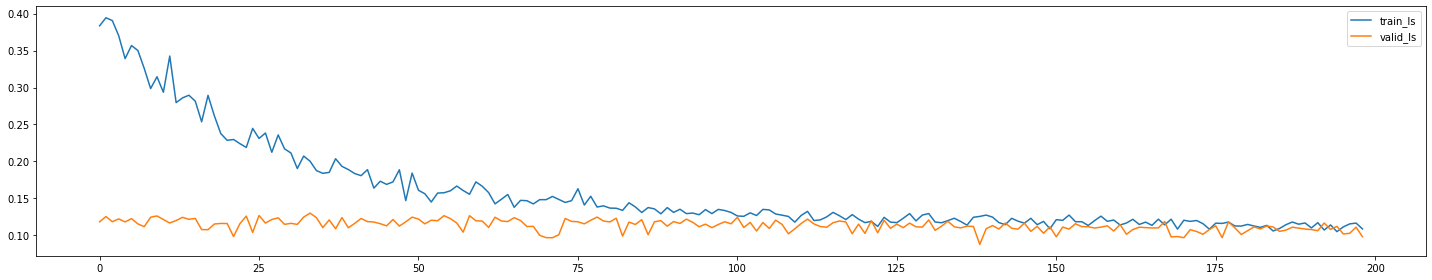

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, axs = plt.subplots(1, 1, tight_layout=True, figsize = (20,4))

epoch = 199
axs.plot(range(epoch), train_ls[1:], label = 'train_ls')
axs.plot(range(epoch), valid_ls[1:], label = 'valid_ls')
axs.legend()



In [ ]:
(np.array(train_ls[510:560]) < np.array(valid_ls[510:560])).sum()

2

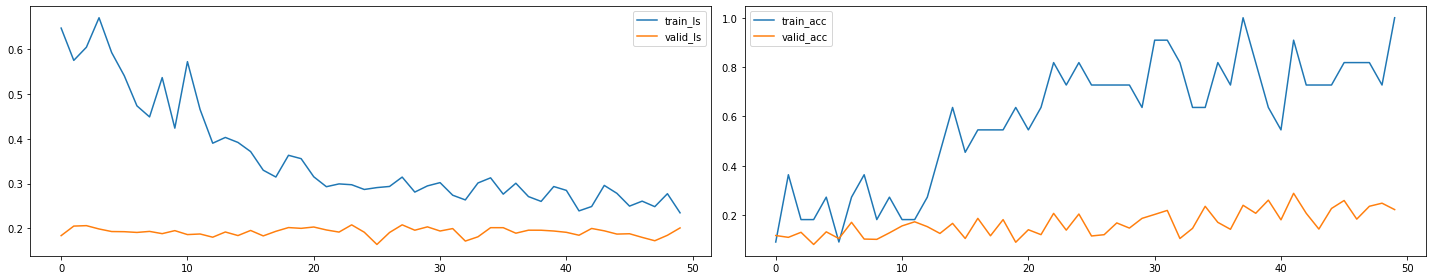

In [ ]:
fig, axs = plt.subplots(1, 2, tight_layout=True, figsize = (20,4))

epoch = 49
axs[0].plot(range(epoch+1), train_ls, label = 'train_ls')
axs[0].plot(range(epoch+1), valid_ls, label = 'valid_ls')
axs[0].legend()
axs[1].plot(range(epoch+1), train_acc, label = 'train_acc')
axs[1].plot(range(epoch+1), valid_acc, label = 'valid_acc')
axs[1].legend()


In [ ]:
# A1 BALD
acquisition_hist, successor1_hist, successor2_hist, scores, pool_idx = active_learning_procedure(
                                                                                X_test,
                                                                                y_test,
                                                                                X_pool,
                                                                                y_pool,
                                                                                X_initial,
                                                                                y_initial,
                                                                                n_queries = 20,
                                                                                n_instances = 5,
                                                                                Model_A = 1, Model_S1 = 2, Model_S2 = 3)
with open('res_bald_A1.npy', 'wb') as f:
    np.save(f, acquisition_hist)
    np.save(f, successor1_hist)
    np.save(f, successor2_hist)
    np.save(f, scores)

from google.colab import files
files.download('res_bald_A1.npy')


Query 1: 0.5172(Model A)    |     0.5121(Model S1) - 0.5068(Model S2) 
Query 2: 0.5731(Model A)    |     0.5851(Model S1) - 0.5717(Model S2) 
Query 3: 0.5816(Model A)    |     0.5838(Model S1) - 0.5815(Model S2) 
Query 4: 0.6191(Model A)    |     0.6176(Model S1) - 0.5799(Model S2) 
Query 5: 0.6041(Model A)    |     0.6040(Model S1) - 0.5939(Model S2) 
Query 6: 0.6075(Model A)    |     0.6114(Model S1) - 0.5853(Model S2) 
Query 7: 0.6382(Model A)    |     0.6271(Model S1) - 0.5949(Model S2) 
Query 8: 0.6534(Model A)    |     0.6434(Model S1) - 0.6136(Model S2) 
Query 9: 0.6739(Model A)    |     0.6502(Model S1) - 0.6426(Model S2) 
Query 10: 0.6837(Model A)    |     0.6898(Model S1) - 0.6706(Model S2) 
Query 11: 0.6866(Model A)    |     0.6967(Model S1) - 0.6757(Model S2) 
Query 12: 0.7040(Model A)    |     0.7084(Model S1) - 0.6795(Model S2) 
Query 13: 0.7101(Model A)    |     0.7203(Model S1) - 0.6860(Model S2) 
Query 14: 0.7108(Model A)    |     0.7165(Model S1) - 0.6885(Model S2) 
Q

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#iid
acquisition_hist, successor1_hist, successor2_hist, scores, pool_idx = active_learning_procedure(
                                                                                X_test,
                                                                                y_test,
                                                                                X_pool,
                                                                                y_pool,
                                                                                X_initial,
                                                                                y_initial,
                                                                                n_queries = 20,
                                                                                n_instances = 5,
                                                                                sample_strategy = 'iid',
                                                                                Model_A = 1, Model_S1 = 2, Model_S2 = 3)
with open('res_iid_A1.npy', 'wb') as f:
    np.save(f, acquisition_hist)
    np.save(f, successor1_hist)
    np.save(f, successor2_hist)
    np.save(f, scores)

from google.colab import files
files.download('res_iid_A1.npy')

Query 1: 0.5759(Model A)    |     0.5724(Model S1) - 0.5757(Model S2) 
Query 2: 0.5941(Model A)    |     0.5986(Model S1) - 0.5411(Model S2) 
Query 3: 0.5933(Model A)    |     0.5852(Model S1) - 0.5392(Model S2) 
Query 4: 0.6112(Model A)    |     0.6185(Model S1) - 0.5790(Model S2) 
Query 5: 0.6347(Model A)    |     0.6320(Model S1) - 0.5934(Model S2) 
Query 6: 0.6363(Model A)    |     0.6505(Model S1) - 0.6355(Model S2) 
Query 7: 0.6621(Model A)    |     0.6637(Model S1) - 0.6596(Model S2) 
Query 8: 0.6904(Model A)    |     0.6953(Model S1) - 0.6853(Model S2) 
Query 9: 0.7088(Model A)    |     0.6994(Model S1) - 0.7058(Model S2) 
Query 10: 0.7192(Model A)    |     0.7223(Model S1) - 0.6946(Model S2) 
Query 11: 0.7255(Model A)    |     0.7243(Model S1) - 0.7115(Model S2) 
Query 12: 0.7210(Model A)    |     0.7279(Model S1) - 0.6974(Model S2) 
Query 13: 0.7392(Model A)    |     0.7469(Model S1) - 0.6992(Model S2) 
Query 14: 0.7507(Model A)    |     0.7410(Model S1) - 0.7249(Model S2) 
Q

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# A2 BALD
acquisition_hist, successor1_hist, successor2_hist, scores, pool_idx = active_learning_procedure(
                                                                                X_test,
                                                                                y_test,
                                                                                X_pool,
                                                                                y_pool,
                                                                                X_initial,
                                                                                y_initial,
                                                                                n_queries = 20,
                                                                                n_instances = 5,
                                                                                Model_A = 2, Model_S1 = 1, Model_S2 = 3)
with open('res_bald_A2.npy', 'wb') as f:
    np.save(f, acquisition_hist)
    np.save(f, successor1_hist)
    np.save(f, successor2_hist)
    np.save(f, scores)

from google.colab import files
files.download('res_bald_A2.npy')

Query 1: 0.5159(Model A)    |     0.5268(Model S1) - 0.5239(Model S2) 
Query 2: 0.5367(Model A)    |     0.5344(Model S1) - 0.5229(Model S2) 
Query 3: 0.5546(Model A)    |     0.5660(Model S1) - 0.5598(Model S2) 
Query 4: 0.6095(Model A)    |     0.5953(Model S1) - 0.5521(Model S2) 
Query 5: 0.5972(Model A)    |     0.6007(Model S1) - 0.5827(Model S2) 
Query 6: 0.6184(Model A)    |     0.6180(Model S1) - 0.5932(Model S2) 
Query 7: 0.6376(Model A)    |     0.6351(Model S1) - 0.6146(Model S2) 
Query 8: 0.6542(Model A)    |     0.6511(Model S1) - 0.6312(Model S2) 
Query 9: 0.6442(Model A)    |     0.6503(Model S1) - 0.6330(Model S2) 
Query 10: 0.6460(Model A)    |     0.6279(Model S1) - 0.6009(Model S2) 
Query 11: 0.6558(Model A)    |     0.6443(Model S1) - 0.6517(Model S2) 
Query 12: 0.6694(Model A)    |     0.6723(Model S1) - 0.6615(Model S2) 
Query 13: 0.6647(Model A)    |     0.6740(Model S1) - 0.6592(Model S2) 
Query 14: 0.6846(Model A)    |     0.6790(Model S1) - 0.6488(Model S2) 
Q

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# A3 BALD
acquisition_hist, successor1_hist, successor2_hist, scores, pool_idx = active_learning_procedure(
                                                                                X_test,
                                                                                y_test,
                                                                                X_pool,
                                                                                y_pool,
                                                                                X_initial,
                                                                                y_initial,
                                                                                n_queries = 20,
                                                                                n_instances = 5,
                                                                                Model_A = 3, Model_S1 = 2, Model_S2 = 1)
with open('res_bald_A3.npy', 'wb') as f:
    np.save(f, acquisition_hist)
    np.save(f, successor1_hist)
    np.save(f, successor2_hist)
    np.save(f, scores)

from google.colab import files
files.download('res_bald_A3.npy')

Query 1: 0.5202(Model A)    |     0.5241(Model S1) - 0.5100(Model S2) 
Query 2: 0.5409(Model A)    |     0.5477(Model S1) - 0.5385(Model S2) 
Query 3: 0.5403(Model A)    |     0.5781(Model S1) - 0.5667(Model S2) 
Query 4: 0.5873(Model A)    |     0.5936(Model S1) - 0.5902(Model S2) 
Query 5: 0.6156(Model A)    |     0.6094(Model S1) - 0.5887(Model S2) 
Query 6: 0.6261(Model A)    |     0.6194(Model S1) - 0.6095(Model S2) 
Query 7: 0.6578(Model A)    |     0.6520(Model S1) - 0.6437(Model S2) 
Query 8: 0.6525(Model A)    |     0.6841(Model S1) - 0.6843(Model S2) 
Query 9: 0.6625(Model A)    |     0.6834(Model S1) - 0.6649(Model S2) 
Query 10: 0.6777(Model A)    |     0.6878(Model S1) - 0.6720(Model S2) 
Query 11: 0.6844(Model A)    |     0.6850(Model S1) - 0.6745(Model S2) 
Query 12: 0.6821(Model A)    |     0.6986(Model S1) - 0.6816(Model S2) 
Query 13: 0.6837(Model A)    |     0.7114(Model S1) - 0.7054(Model S2) 
Query 14: 0.7137(Model A)    |     0.7225(Model S1) - 0.7208(Model S2) 
Q

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# check stopping creterion for bald:
train_x = X_initial
train_y = y_initial

for query_idx in pool_idx[:2]:
  train_x = np.vstack((train_x, X_pool[query_idx]))
  train_y = np.hstack((train_y, y_pool[query_idx]))

  X_pool = np.delete(X_pool, query_idx, axis=0)
  y_pool = np.delete(y_pool, query_idx, axis=0)

  valid_idx = np.random.randint(0, len(y_pool), 1000)
  x_valid = X_pool[valid_idx]
  y_valid = y_pool[valid_idx]

  m = Model1(784, 10, data_num = len(train_x)).to(device)
  optim = torch.optim.Adam(m.parameters(), lr=0.001)
  train_ls, valid_ls = train(m, optim, 1000, 
                              train_x, train_y, 
                              x_valid, y_valid,
                              verbose = False)
  y_sample = np.stack([torch.exp(m(X_test.to(device))).detach().cpu().numpy() for t in range(100)])
  y_pred = y_sample.mean(axis = 0).argmax(axis = 1)
  acc = np.equal(y_pred, y_test).sum().item()/len(y_test)
  print('data size {}:  acc {}'.format(len(train_x), acc))

data size 15:  acc 0.4555
data size 20:  acc 0.4485


In [ ]:
pool_idx[:8]

[array([13049]),
 array([8483]),
 array([31070]),
 array([52071]),
 array([19800]),
 array([19032]),
 array([50050]),
 array([4796])]

In [ ]:
with open('res_bald_A1.npy', 'wb') as f:
    np.save(f, acquisition_hist)
    np.save(f, successor1_hist)
    np.save(f, successor2_hist)
    np.save(f, scores)

from google.colab import files
files.download('res_bald_A1.npy') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
with open('res_bald_A1.npy', 'rb') as f:
    acquisition_hist = np.load(f)
    successor1_hist = np.load(f)
    successor2_hist = np.load(f)
    scores = np.load(f)

In [ ]:
y_pred = m(X_test.to(device))

In [ ]:
a = F.nll_loss(y_pred, y_test.to(device), reduction='none')

In [ ]:
F.nll_loss(y_pred, y_test.to(device))

tensor(2.1675, device='cuda:0', grad_fn=<NllLossBackward>)

In [ ]:
a.mean()

tensor(2.1675, device='cuda:0', grad_fn=<MeanBackward0>)

In [ ]:
y_test

tensor([6, 7, 7,  ..., 1, 5, 5])